# WHONDRS data preprocessing notebook

We want to predict sediment respiration rates based on:
1. site data (in situ water samples - isotopes, chemical conc./presence)
2. intermediate scale data (site metadata, e.g. what an observer sees)
3. large scale data (satellite data, stream order)

This notebook will preprocess the WHONDRS data for use with machine learning. 
In this case, preprocessing means pulling out exactly the data to be used 
and applying any reformatting/reordering needed to create a single input file 
for the machine learning.

There are multiple respiration rates per site because they come from
upstream, midstream, and downstream sampling locations.  Some site
metadata encompass the whole site and other metadata are specific to
the U, M, and D "subsites".  Here, we attempt to keep U, M, and D
data points as separate as possible.

The data sets merged here are:
1. WHONDRS **sediment** respiration rate (the target variable for predictions), 
2. WHONDRS site metadata (range of scales, recorded by observers),
3. WHONDRS **sediment** FTICR chemical presence/absence,
4. WHONDRS site data (isotopes, C and N percentages, flow cytometry, grain size, and NPOC).

(#1 and #2 are already pre-merged).

Large scale data from RiverATLAS (stream order, water depth, climatic and land use
indices) are merged separately during ML workflow execution. This additional
merge is carried out seprately because it draws on data outside of WHONDRS while
all data merged here are WHONDRS S19S data.  WHONDRS S19S has a broader range of input
variables (i.e. features) than subsequent WHONDRS ICON-ModEx and SSS sampling.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp

# Full path of directory that contains WHONDRS data
csv_path = "/pw/dev/global-river-databases/WHONDRS/"

# Load respiration rate and site observer metadata

Respiration rate will be the key output of the ML models.  The presence/absence of data from each site in this data set determines all other record queries.

In [2]:
# Load the metadata (md) and 
# respiration rate (rr) data.
# Here, the Sample_ID can be used 
# to access a whole sample, e.g.:
# df_site_meta.loc['S19S_0001-U',:]
df_md_rr = pd.read_csv(
    csv_path+"ICON-ModEx_Data.csv",
    index_col='Sample_ID',
    header=0)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)

# If there are any missing respiration rates, drop whole rows from the very beginning:
print('Starting with DF shape: '+str(df_md_rr.shape))
print('Retaining only S19S data...')
df_md_rr = df_md_rr.filter(axis='index', regex="S19S")
print('Current DF shape: '+str(df_md_rr.shape))
print('Dropping any NaN (missing) normalized respiration rates...')
df_md_rr.dropna(axis='index', subset=['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'], 
                how='any', inplace=True)
print('Current DF shape: '+str(df_md_rr.shape))

df_md_rr

Starting with DF shape: (699, 58)
Retaining only S19S data...
Current DF shape: (291, 58)
Dropping any NaN (missing) normalized respiration rates...
Current DF shape: (224, 58)


,Sample_Kit_ID,Date,Median_Time_Unix,Median_Time_Local,Local_Timezone,Mean_DO_mg_per_L,DO_sd,Mean_DO_percent_saturation,DO_percent_saturation_sd,Mean_Temp_Deg_C,Temp_sd,Respiration_Rate_mg_DO_per_L_per_H,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment,Type,Respiration_R_Squared,Respiration_R_Squared_Adj,Respiration_p_value,Total_Incubation_Time_Min,Number_Points_In_Respiration_Regression,Number_Points_Removed_Respiration_Regression,DO_Concentration_At_Incubation_Time_Zero,Site_ID,Sample_Latitude,Sample_Longitude,MiniDot_Latitude,MiniDot_Longitude,MiniDot_Start_Time,MiniDot_End_Time,MiniDot_ID,pH,Contact_First_Name,Contact_Last_Name,Organization,Email,Site_Name,Stream_Name,City,State,Country,Weather,Intermittent_or_Perennial,General_Vegetation,Hydrogeomorphology,River_Gradient,MiniDot_Sediment,Water_Temperature,Water_Depth_cm,Depositional_Type,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,Sediment_Collection_Depth_cm,MiniDot_Notes,Additional_Sampling_Notes,Hydrograph_Online,Hydrograph_Other,Water_volume_Flag,Notes
Sample_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S19S_0019-D,S19S_0019,8/19/2019,NaN,NaN,EST,11.46,NaN,121.9,NaN,18.3,NaN,-1.43,-4.60,Measured_10mL,0.994539,0.993629,0.000723,129,8,0,8.53,NaN,35.956381,-84.278999,35.9563807,-84.278999,NaN,NaN,NaN,8.0,Geoff,Schwaner,Battelle-NEON D07,NaN,National Ecological Observatory (NEON) site: WALK,Walker Branch,Oak Ridge,Tennessee,USA,Partly cloudy,Perennial,Broadleaf deciduous tree,Single-channel straight,"Relatively flat/gentle gradient (e.g., valleys)",Gravel/cobble (>2mm),18.3,6.0,Shallow waters near the shore,No or almost no direct sunlight (>80% canopy c...,Low,No,NaN,NaN,NaN,NaN,NaN,False,NaN
S19S_0019-M,S19S_0019,8/19/2019,NaN,NaN,EST,11.46,NaN,121.9,NaN,18.3,NaN,-11.47,-36.16,Measured_10mL,0.958213,0.916426,0.039935,36,3,0,8.13,NaN,35.956601,-84.278910,35.956601,-84.278910,NaN,NaN,NaN,8.0,Geoff,Schwaner,Battelle-NEON D07,NaN,National Ecological Observatory (NEON) site: WALK,Walker Branch,Oak Ridge,Tennessee,USA,Partly cloudy,Perennial,Broadleaf deciduous tree,Single-channel straight,"Relatively flat/gentle gradient (e.g., valleys)",Gravel/cobble (>2mm),18.3,8.0,Shallow waters near the shore,Partial direct sunlight (50-80% canopy cover),Low,No,NaN,NaN,NaN,NaN,NaN,False,NaN
S19S_0019-U,S19S_0019,8/19/2019,NaN,NaN,EST,11.46,NaN,121.9,NaN,18.3,NaN,-3.75,-11.18,Measured_10mL,0.960563,0.940844,0.008945,47,4,0,8.44,NaN,35.957280,-84.278698,35.9572803,-84.278698,NaN,NaN,NaN,8.0,Geoff,Schwaner,Battelle-NEON D07,NaN,National Ecological Observatory (NEON) site: WALK,Walker Branch,Oak Ridge,Tennessee,USA,Partly cloudy,Perennial,Broadleaf deciduous tree,Single-channel straight,"Relatively flat/gentle gradient (e.g., valleys)",Gravel/cobble (>2mm),18.3,12.0,Pool lip,Partial direct sunlight (50-80% canopy cover),No,Low,NaN,NaN,NaN,NaN,NaN,False,NaN
S19S_0006-D,S19S_0006,7/29/2019,NaN,NaN,EST,NaN,NaN,NaN,NaN,25.7,NaN,NaN,-1575.97,Theoretical,-9999.000000,-9999.000000,-9999.000000,-9999,-9999,-9999,4.29,NaN,39.311369,-76.717163,39.311369,-76.717163,NaN,NaN,NaN,7.5,Ben,Glass-Siegel,Baltimore Ecosystem Study,NaN,NSF Long Term Ecological Research (LTER) site:...,Dead Run,Baltimore,Maryland,USA,Sunny,Perennial,Broadleaf deciduous tree. Shrub,Single-channel meandering,"Relatively flat/gentle gradient (e.g., valleys)",Gravel/cobble (>2mm),25.7,6.0,Shallow waters near the shore,Partial direct sunlight (50-80% canopy cover),No,Low,NaN,NaN,Conductivity: 1430 millisiemens. Conductivity ...,NaN,NaN,True,NaN
S19S_0006-M,S19S_0006,7/29/2019,NaN,NaN,EST,NaN,NaN,NaN,NaN,25.7,NaN,-1.05,-3.28,Measured_10mL,0.754172,0.692715,0.004980,120,6,0,6.77,NaN,39.311620,-76.717316,39.31162,-76.717316,NaN,NaN,NaN,7.5,Ben,Glass-Siegel,Baltimore Ecosystem Study,NaN,NSF Long Term Ecological Research (LTER) site:...,Dead Run,Baltimore,Maryland,USA,Sunny,Perennial,Broadleaf deciduous tree. Shrub,Single-channel meandering,"Relatively flat/gentle gradient (e.g., valleys)",Gravel/cobble (>2mm

# Load FTICR data into Pandas DataFrame

In [3]:
# In this file, site ID is in the header
# so sites/samples are along the columns 
# rather than the rows. Due to alignment
# issues, mass is not exact but we can use
# it as an index since it is the first
# column and conveniently unique.
df_fticr = pd.read_csv(
    csv_path+"FTICR/Processed_S19S_Sediments_Water_2-2_newcode.csv.adj",
    header=0,
    index_col='Mass')

# Instead of transposing the dataframe and creating a new
# dataframe that is indexed by sample_id (e.g. somthing like:
# df_fticr_transposed = df_fticr.transpose().set_index()),
# note that there are U, M, and D data points as well as P2,
# p05 designations. The solution is to select columns of data
# based on sample similar to the site metadata.

# The bigger problem is that the data are not 100% consistent
# in that only some sites have U, M, D subsamples, etc.  There
# can be anywhere from 0 to 6 entries per sample_ID, some of
# which are U,M,D and some are replicates.  So here, we will
# pull out all the values associated with a sample_id, add them
# together, and any values greater than 0 are replaced with 1.
# This means all replicates, and ion-accumulation
# times (the PXX values) are merged together into a single
# presence-absence string for that site BUT all U,
# M, D sites are kept apart.  Any site that is missing (e.g.
# S19S_0001-M was not found, but S19S_0001-U was found) has
# NaN data for the FTICR features.

# We will select a string of 0's and 1's from a column based
# on the sample_id.  An alternative approach is to weight 
# the 0's and 1's based on the associated variables with 
# each chemical (e.g. AI, DBE, NOSC). For example, the 
# final value could be:
# (AI + DBE + NOSC)*(presence/absence) - but this additional
# weighting has NOT been applied.

#====================================================
# Set dictionary for mapping units of this data set
#====================================================
# Use chemical presence/absence
# to weight AI, DBE, and NOSC variables and a
# few others.  Here, I will use the column names
# in the chemical presence/absence file to generate
# a presence/absence weighted value for each variable.
# There are a few others to choose from, but these
# seem to be the most relevant.
    
chem_pres_data_to_use = {
    'AI':np.dtype('float'),
    'AI_Mod':np.dtype('float'),
    'DBE':np.dtype('float'),
    'DBE_O':np.dtype('float'),
    'GFE':np.dtype('float'),
    'NOSC':np.dtype('float'),
    'delGcox0PerCmol':np.dtype('float'),
    'delGcoxPerCmol':np.dtype('float'),
    'lamO20':np.dtype('float'),
    'lamO2':np.dtype('float'),
    'delGd0':np.dtype('float'),
    'delGd':np.dtype('float'),
    'n_chems':np.dtype('float'),
    'skew_lamO20':np.dtype('float'),
    'skew_lamO2':np.dtype('float'),
    'perc_AminoSugar':np.dtype('float'),
    'perc_Carb':np.dtype('float'),
    'perc_ConHC':np.dtype('float'),
    'perc_Lignin':np.dtype('float'),
    'perc_Lipid':np.dtype('float'),
    'perc_Other':np.dtype('float'),
    'perc_Protein':np.dtype('float'),
    'perc_Tannin':np.dtype('float'),
    'perc_UnsatHC':np.dtype('float')
}
    
len(chem_pres_data_to_use.keys())

24

In [4]:
# Function to extract FTICR data for a given site ID.

# Find all the records associated with a given
# sample_id and add up all presence/absence.
# If a Sample_ID does not specify U, M, or D
# then all those values will be combined!
def get_fticr_data(df_fticr_in, site_id, dict_index_to_use, plot_counter=1):
    
    # Sum the presence (1) and absence (0) of chemicals at the
    # site. This is done to sum over potentially different
    # ion accumulation times at each site. This filter can be
    # adjusted to exclude different _p* values.
    tmp_filter = df_fticr_in.filter(regex=site_id).sum(axis=1) > 0
    tmp_counts = tmp_filter.astype(float)
    
    # Initialize dataframe with NaN whose values will be
    # filled in.
    df_out = pd.DataFrame(np.nan,
        columns=list(dict_index_to_use.keys()),
        index=[site_id])
    
    # Check for no data found for this site
    if tmp_counts.sum() == 0:
        print('No FTICR data found for this site!')
        return df_out.iloc[0,:]

    # Now, create an "average detected index" (ADI) for each
    # of the desired indices.
    for index_name in dict_index_to_use.keys():
        
        # Special case for number of chemicals
        if index_name == "n_chems":
            df_out[index_name] = tmp_counts.sum()
        
        # Special case for skew of index:
        elif index_name[0:4] == "skew":
            # Get variable to skew
            this_index = index_name[5:len(index_name)]
            adi_list = df_fticr_in[this_index]
            adi_avg = np.multiply(adi_list,tmp_counts).sum()/tmp_counts.sum()
            
            # Mask out missing values
            masked = adi_list*tmp_counts
            just_this_sample = masked[masked != 0]
            
            # Plot internal result
            if plot_counter == 0:
                fig, ax = plt.subplots()
                ax.hist(just_this_sample,bins=50)
                plt.title(index_name)
                plot_counter = 1
            
            # Compute skew
            df_out[index_name] = sp.stats.skew(just_this_sample.to_numpy(),nan_policy="omit")
            
        # Special case for percent of category
        elif index_name[0:4] == "perc":
                
            # Get the categories and name of requested category
            adi_list = df_fticr_in['Class']
            this_category = index_name[5:len(index_name)]
            categories_this_sample = adi_list[tmp_filter]
            
            total_this_sample = np.shape(categories_this_sample)[0]
            present_this_category = categories_this_sample == this_category
            df_out[index_name] = present_this_category.astype(int).sum()/total_this_sample
            
        # General case
        else:        
            adi_list = df_fticr_in[index_name]
            adi_avg = np.multiply(adi_list,tmp_counts).sum()/tmp_counts.sum()
            df_out[index_name] = adi_avg
            
    # Done with ADI looping, but still need to change
    # the dataframe into exactly the same format
    # as the other data sets' dataframes
    return df_out.iloc[0,:]

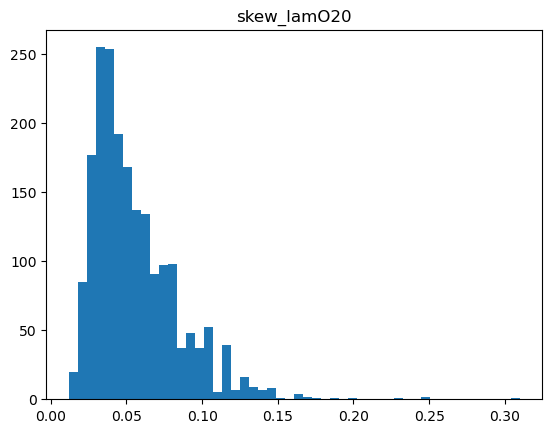

In [5]:
# Test function with one site
tmp = get_fticr_data(df_fticr, 'S19S_0089-U', chem_pres_data_to_use,plot_counter=0)

# Test function over all sites
#for site in df_md_rr.index:
#    print(site)
#    tmp = get_fticr_data(df_fticr, site, chem_pres_data_to_use)

# Load sample isotope, NPOC, grain size, flow cytometry, and CN data

In [6]:
df_isotopes = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_Isotopes.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
isotopes_data_to_use = {
    'del_15N_permil':np.dtype('float'),
    'del_13C_permil':np.dtype('float')
}

df_isotopes

,Study_Code,del_15N_permil,del_13C_permil,Date_Run
Sample_ID,,,,
S19S_0001-D,WHONDRS_S19S,1.23,-22.06,2022-10-24
S19S_0001-M,WHONDRS_S19S,-1.28,-26.27,2022-10-24
S19S_0001-U,WHONDRS_S19S,1.77,-23.20,2022-10-24
S19S_0003-D,WHONDRS_S19S,2.61,-26.03,2022-10-24
S19S_0003-M,WHONDRS_S19S,4.91,-25.32,2022-10-24
...,...,...,...,...
S19S_0099-M,WHONDRS_S19S,-7.42,-2.45,2022-10-24
S19S_0099-U,WHONDRS_S19S,-4.55,-0.70,2022-10-24
S19S_0100-D,WHONDRS_S19S,4.82,-16.68,2022-10-24


In [16]:
df_npoc_inc = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_NPOC_INC.csv.adj",
    header=0,
    index_col='Sample_ID')

df_npoc_field = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_NPOC_Field.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
npoc_inc_data_to_use = {
    'NPOC_INC_mg_per_L_as_C':np.dtype('float')
}

npoc_field_data_to_use = {
    'NPOC_Field_mg_per_L_as_C':np.dtype('float')
}

df_npoc_inc

,Study_Code,NPOC_INC_mg_per_L_as_C
Sample_ID,,
S19S_0044-M,WHONDRS_S19S,14.77
S19S_0016-D,WHONDRS_S19S,5.72
S19S_0015-D,WHONDRS_S19S,11.21
S19S_0050-D,WHONDRS_S19S,7.15
S19S_0032-D,WHONDRS_S19S,25.64
...,...,...
S19S_0075-U,WHONDRS_S19S,8.28
S19S_0055-U,WHONDRS_S19S,18.88
S19S_0042-M,WHONDRS_S19S,27.92


In [17]:
df_npoc_field

,Study_Code,NPOC_Field_mg_per_L_asC
Sample_ID,,
S19S_0067-D,WHONDRS_S19S,24.32
S19S_0072-M,WHONDRS_S19S,8.90
S19S_0073-U,WHONDRS_S19S,20.24
S19S_0071-U,WHONDRS_S19S,31.58
S19S_0064-M,WHONDRS_S19S,21.81
...,...,...
S19S_0087-U,WHONDRS_S19S,25.61
S19S_0067-U,WHONDRS_S19S,46.59
S19S_0094-D,WHONDRS_S19S,7.57


In [8]:
df_grainsize = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_GrainSize.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
grainsize_data_to_use = {
    'Percent_Fine_Sand':np.dtype('float'),
    'Percent_Med_Sand':np.dtype('float'),
    'Percent_Coarse_Sand':np.dtype('float'),
    'Percent_Tot_Sand':np.dtype('float'),
    'Percent_Clay':np.dtype('float'),
    'Percent_Silt':np.dtype('float')
}

df_grainsize

,Study_Code,Percent_Fine_Sand,Percent_Med_Sand,Percent_Coarse_Sand,Percent_Tot_Sand,Percent_Clay,Percent_Silt
Sample_ID,,,,,,,
S19S_0001-D,WHONDRS_S19S,21.1,69.7,0.1,90.9,0.0,9.1
S19S_0001-M,WHONDRS_S19S,65.3,26.0,0.6,91.9,6.9,1.2
S19S_0001-U,WHONDRS_S19S,20.4,68.6,2.1,91.1,8.9,0.0
S19S_0003-D,WHONDRS_S19S,29.9,56.5,0.7,87.1,2.3,10.6
S19S_0003-M,WHONDRS_S19S,19.2,66.2,1.7,87.1,2.2,10.7
...,...,...,...,...,...,...,...
S19S_0099-M,WHONDRS_S19S,9.1,34.5,47.9,91.5,8.5,0.0
S19S_0099-U,WHONDRS_S19S,9.8,37.3,41.9,89.0,7.8,3.2
S19S_0100-D,WHONDRS_S19S,21.0,31.3,11.9,64.2,17.7,18.1


In [9]:
df_flowcyto = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_FlowCytometry.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
flowcyto_data_to_use = {
    'Total_Bacteria_cells_per_gram':np.dtype('float'),
    'Total_Photorophs_cells_per_gram':np.dtype('float'),
    'Total_Heterotrophs_cells_per_gram':np.dtype('float')
}

df_flowcyto

,Study_Code,Total_Bacteria_cells_per_gram,Total_Photorophs_cells_per_gram,Total_Heterotrophs_cells_per_gram
Sample_ID,,,,
S19S_0010-U,WHONDRS_S19S,1.760000e+09,35000000,1.720000e+09
S19S_0010-M,WHONDRS_S19S,2.310000e+09,53500000,2.260000e+09
S19S_0010-D,WHONDRS_S19S,1.470000e+09,47000000,1.420000e+09
S19S_0023-U,WHONDRS_S19S,2.200000e+09,3930000,2.190000e+09
S19S_0023-M,WHONDRS_S19S,2.000000e+09,115000000,1.890000e+09
...,...,...,...,...
S19S_0052-M,WHONDRS_S19S,3.070000e+08,39800000,2.670000e+08
S19S_0052-D,WHONDRS_S19S,2.520000e+08,28200000,2.240000e+08
S19S_0072-U,WHONDRS_S19S,2.780000e+08,80300000,1.980000e+08


In [10]:
df_cn = pd.read_csv(
    csv_path+"site-data/WHONDRS_S19S_Sediment_CN.csv.adj",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
cn_data_to_use = {
    'C_percent':np.dtype('float'),
    'N_percent':np.dtype('float')
}

df_cn

,Study_Code,C_percent,N_percent
Sample_ID,,,
S19S_0001-D,WHONDRS_S19S,0.24,0.10
S19S_0001-M,WHONDRS_S19S,0.24,0.08
S19S_0001-U,WHONDRS_S19S,0.24,0.09
S19S_0003-D,WHONDRS_S19S,0.59,0.10
S19S_0003-M,WHONDRS_S19S,0.54,0.11
...,...,...,...
S19S_0099-M,WHONDRS_S19S,3.63,0.08
S19S_0099-U,WHONDRS_S19S,4.03,0.09
S19S_0100-D,WHONDRS_S19S,2.42,0.20


# Load RiverATLAS-derived stream order & other data
This data is added during the workflow execution using dynamic look up with each site's lon/lat.

# Mix and match data for each respiration rate record

In [ ]:
# As with many things in Python, you need to be very careful how
# you access it.  See:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#indexing-view-versus-copy
# Here, I pull out just the columns I think are most related to
# the intermediate scale data that are available in this file.
# Water sample scale data (e.g. pH, DO, temperature, can be
# included in the small scale analysis.)  Note that quite a
# few columns are commented out WITHOUT COMMMENTS - this means
# that they are simply removed for now so that I can start
# with a simple data set.  I want a mix of one-hot and numerical
# data to check the pipeline.  I did not check for missing
# data in the uncommented variables.

# Also, which columns that are pulled out depends on the
# U, M, D status of the respiration rate sample.  So here
# we loop over the respiration rates and adjust the
# names of the columns we pull out from the site metadata
# file based on the respiration rate U, M, D.
for row in df_resp_rate_used.index:

    # Determine sample_id
    sample_id = df_resp_rate_used.iloc[row,0]
    
    # Determine U, M, or D (up, mid, or down-stream)
    umd = df_resp_rate_used.iloc[row,1]
    
    # Determine respiration rate
    resp_rate = df_resp_rate_used.iloc[row,2]
    
    # Set a dictionary with the variables to be used
    # (the column name in the file) and the data type.
    site_data_to_use = {
#        'Sample_ID':np.dtype('str'),   # This is already set to index
        'General_Vegetation':'category',
        'Hydrogeomorphology':'category',
        'River_Gradient':'category',
#       'Intermittent_or_Perennial',  # MISSING DATA
        'Sediment':'category',
        umd+'S_Latitude_dec.deg':np.dtype('float'),
#        umd+'S_Longitude_dec.deg':np.dtype('float')   # Less climatically relevant than latitude
        umd+'S_Water.Column.Height_cm':np.dtype('float'),
        umd+'S_Depositional.Type':'category',
        umd+'S_Algal.Mat.Coverage':'category',
        umd+'S_Macrophyte.Coverage':'category',
        umd+'S_Sunlight.Access_Perc.Canopy.Cover':'category',
        'SW_pH':np.dtype('float'),
        'DO_perc.sat':np.dtype('float'),
        'DO_mg.per.L':np.dtype('float'),
        'SW_Temp_degC':np.dtype('float')
#       'Discharge_Link',  # Comment out because URL to external data.
#       'Primary.Sources.Flow.Variation',   # Missing Data
#       'Met.Station.Nearby',
#       'Met.Station',
#       'Precipitation.Within.Week',
#       'Number.Days.Since.Precip',
#       'Dam.Upstream.Site',
#       'Dam',   # Comment out because lots of Not_Provided
#       'Contamination.Source.Upstream'
    }
    
    # Pull out just the variables we want
    df_site_meta_used = df_site_meta.loc[sample_id, 
        list(site_data_to_use.keys())]
    
    df_stream_order_used = df_stream_order.loc[sample_id, 
        list(stream_order_data_to_use.keys())]

    # For solution on how to search for multiple columns:
    # See https://stackoverflow.com/questions/12569730/sum-all-columns-with-a-wildcard-name-search-using-python-pandas
    if (all_chems):
        # This will append all the chemical presence/absence data
        df_tmp = df_chem_pres.filter(regex=sample_id).sum(axis=1) > 0
        df_chem_pres_used = df_tmp.astype(float)
    else:
        # This will append only the *requested*
        # average detected indeces.
        df_tmp = df_chem_pres.filter(regex=sample_id).sum(axis=1) > 0
        df_01 = df_tmp.astype(float)
    
        # Make an empty dataframe whose values will be
        # filled in.
        df_adi_used = pd.DataFrame(
            columns=list(chem_pres_data_to_use.keys()),
            index=[sample_id])
    
        # Now, compute the "average detected index" (ADI) for
        # each requested variable.
        # TO DO: make this more intelligent by creating a framework
        # that names variables according to op_var where op is the
        # operator (e.g. avg, n, skew, percent) and var is the feature
        # in the data table that that operator will work on.  A loop
        # will look like:
        # for each name:
        #     get operator_name
        #     get variable_name
        #     if operator == type1:
        #         operate
        #     elif operator == type2:
        #         operate
        #     ...
        #     else:
        #         operator not recognized, panic
        #--------------------------------------------------------------
        for adi_name in chem_pres_data_to_use.keys():
            if adi_name == "n_chems":
                # Special case for number of chemicals
                df_adi_used[adi_name] = df_01.sum()
                
            elif adi_name == "skew_lamO2":
                # Special case for lamO2 skewness:
                adi_list = df_chem_pres['lamO2']
                masked = adi_list*df_01
                just_this_sample = masked[masked != 0]
                df_adi_used[adi_name] = sp.stats.skew(just_this_sample)
                
            elif adi_name == "skew_lamHCO3":
                # Special case for lamHCO3 skewness:                
                adi_list = df_chem_pres['lamHCO3']
                masked = adi_list*df_01
                just_this_sample = masked[masked != 0]
                df_adi_used[adi_name] = sp.stats.skew(just_this_sample)
                
            elif adi_name[0:4] == "perc":
                # Special case for percent of category
                # Get the categories and name of requested category
                adi_list = df_chem_pres['Class']
                this_category = adi_name[5:len(adi_name)]
                categories_this_sample = adi_list[df_tmp]
                total_this_sample = np.shape(categories_this_sample)[0]
                present_this_category = categories_this_sample == this_category
                df_adi_used[adi_name] = present_this_category.astype(int).sum()/total_this_sample
                
            else:
                adi_list = df_chem_pres[adi_name]
                adi_avg = np.multiply(adi_list,df_01).sum()/df_01.sum()
                df_adi_used[adi_name] = adi_avg
            
        # Done with ADI looping, but still need to change
        # the dataframe into exactly the same format
        # as the other data sets' dataframes
        df_chem_pres_used = df_adi_used.iloc[0,:]

    # Finished with chemical presence/absence.
        
    # Missing samples in isotopes requires checking and filling
    if (sample_id+'_ISO-1' in df_isotopes.index):
        df_isotopes_used = df_isotopes.loc[
            sample_id+'_ISO-1',
            list(isotopes_data_to_use.keys())]
        
    else:
        # This sample is not present in the stream order
        # data set so fill it with NaN.
        df_isotopes_used = pd.DataFrame(
            columns=list(isotopes_data_to_use.keys()), 
            index=[sample_id]).iloc[0,:]
        
    df_ra_so_depth_used = df_ra_so_depth.loc[sample_id, 
        list(ra_so_depth_data_to_use.keys())]
    
    # Append site metadata, stream order, chemical presence,
    # isotopes, and respiration rate to data for this sample.
    row_append_1 = np.append(
        df_site_meta_used.values,
        df_stream_order_used.values,
        axis=0)
    
    row_append_2 = np.append(
        row_append_1,
        df_chem_pres_used.values,
        axis=0)
    
    row_append_3 = np.append(
        row_append_2,
        df_isotopes_used.values,
        axis=0)
    
    row_append_4 = np.append(
        row_append_3,
        df_ra_so_depth_used.values,
        axis=0)
    
    row_of_data = np.append(
        row_append_4,
        [resp_rate],
        axis=0)
    
    #============================================================
    # Original lines
    #row_of_data = np.append(df_site_meta_used.values,[resp_rate],axis=0)
    
    # This is the inplace version of row_of_data.reshape(1,-1)
    # to force numpy and pandas to view this row as 1x10 (2D)
    # and not just a 10 unit list (1D).
    row_of_data.shape = (1,-1)
    #============================================================

    if row == 0:        
        # Merge data type dictionaries to reflect the
        # appending above.  We need to do this so we
        # know the data types of the data we're working
        # with in the final step (see next cell).
        all_data_types = site_data_to_use.copy()
        all_data_types.update(stream_order_data_to_use)
        all_data_types.update(chem_pres_data_to_use)
        all_data_types.update(isotopes_data_to_use)
        all_data_types.update(ra_so_depth_data_to_use)
        all_data_types.update(
            {'rate.mg.per.L.per.h':resp_data_to_use['rate.mg.per.L.per.h']})
        
        # Initialize numpy array to store all the data
        all_data = row_of_data
        
    else:    
        # Append to the data storage
        all_data_tmp = np.append(all_data,row_of_data,axis=0)
        all_data = all_data_tmp
        del all_data_tmp
        
# Initialize output dataframe with
# rows from the respiration rate data
# and columns from the data we want.
df_all_data = pd.DataFrame(
    data=all_data,
    index=df_resp_rate_used.index,
    columns=list(all_data_types.keys()))
df_all_data

In [ ]:
# Compute columnwise statistics (mean, std, min, quantiles, max)
# For text based data, will display the number of results, number
# of unique results, most frequent result and how often that result
# occurred.
df_all_data.describe()

# Filter missing values and map ordinal data

In [ ]:
# Now we need to convert text classes into
# "one-hot" or "one-of-k" data which tells
# the ML model that the data is classicative
# but not necessarily ranked (not numerical).
# This is done with a string of 0's where each
# class is represented by exactly one of the
# zeros being changed into a 1 (so one bit is
# "hot").
#
# A starting point for one-hot
# classification is here:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
#
# I will use this approach for dealing
# with missing data:
# https://stackoverflow.com/questions/48090658/sklearn-how-to-incorporate-missing-data-when-one-hot-encoding
# You can tell when there's missing data in columns
# in which the count line from the .describe()
# operation is less than the total number of rows.
# The missing values are translated to a string of
# all zeros in one-hot encoding.  An unresolved
# question is whether all zeros actually means
# something or whether it is truly ignored by
# the ML model.

# Some classifications overlap just nearly,so merge them
# E.g. an extra period created a whole new class in a few
# cases.
df_all_data = df_all_data.replace(
    'Relatively flat/gentle gradient (e.g.. valleys)',
    'Relatively flat/gentle gradient (e.g. valleys)')
df_all_data = df_all_data.replace(
    'Relatively steep gradient (e.g.. mountainous or hilly terrain)',
    'Relatively steep gradient (e.g. mountainous or hilly terrain)')
df_all_data = df_all_data.replace(
    'Low. The algal mat coverage is not on sediment but nearby',
    'Low')
df_all_data = df_all_data.replace('Low. No','Low')
df_all_data = df_all_data.replace(
    'Submerged aquatic macrophytes abundant without full coverage',
    'High')
df_all_data = df_all_data.replace('bison crossing in riffle','Riffle')
df_all_data = df_all_data.replace(
    'Nearshore of upstream end of sandy vegetated point bar',
    'Shallow waters near the shore')
df_all_data = df_all_data.replace(
    'At the inside bend of a stream. in shallow waters near the shore',
    'Shallow waters near the shore')

# Some numerical data has text in it, convert to numbers.
# For example, some water heights were
# reported qualitatively.  Convert from ranges to
# specific values.
df_all_data = df_all_data.replace('41.1 - may not be correctly calibrated',41.1)
df_all_data = df_all_data.replace('4.62 - may not be correctly calibrated',4.62)
df_all_data = df_all_data.replace('gt 7.5',7.5)
df_all_data = df_all_data.replace('Approx. 100',100)
df_all_data = df_all_data.replace('2 to 6',4)
df_all_data = df_all_data.replace('3 to 13',8)
df_all_data = df_all_data.replace('5 to 25',15)

# Some variables are best as ORDINAL (ranking, 0, 1, 2, 3,...)
# rather than CATEGORICAL.  Define the mapping between the text
# values and the numbers first and then replace the values with
# the integers and change data type from categorical to number.

# First filter out some missing values in ORDINAL variables
df_all_data = df_all_data.replace(
    'the water was very turbid. and no visual inspection was possible. I assume no algal mats present',
    'No')

mapper = {'No':1, 'Low':2, 'High':3}
df_all_data['US_Macrophyte.Coverage'] = df_all_data['US_Macrophyte.Coverage'].replace(mapper)
df_all_data['US_Algal.Mat.Coverage'] = df_all_data['US_Algal.Mat.Coverage'].replace(mapper)

mapper = {
    'Full sunlight (0-20% canopy cover)':1,
    'Accessible direct sunlight (20-50% canopy cover)':2,
    'Partial direct sunlight (50-80% canopy cover)':3,
    'No or almost no direct sunlight (gt80% canopy cover)':4
}
df_all_data['US_Sunlight.Access_Perc.Canopy.Cover'] = df_all_data['US_Sunlight.Access_Perc.Canopy.Cover'].replace(mapper)

all_data_types['US_Macrophyte.Coverage']=np.dtype('float')
all_data_types['US_Algal.Mat.Coverage']=np.dtype('float')
all_data_types['US_Sunlight.Access_Perc.Canopy.Cover']=np.dtype('float')

# Filter out missing data in remaining CATEGORICAL data
df_all_data = df_all_data.replace('Not_Provided',np.nan)
df_all_data = df_all_data.replace('',np.nan)

# Now apply data types
df_all_data = df_all_data.astype(all_data_types)
df_all_data.columns

In [ ]:
df_all_data['rate.mg.per.L.per.h']

# Replace missing numerical values with the mean
Do this here, before one-hot encoding (OHE), because the mean function in Pandas will only return values for numerical columns, not for categorical columns.  This means that when replacing the mean, only columns that have numbers up to this point will have NaN values replaced with the mean.  Missing OHE values will be assigned all zeros.

In [ ]:
df_all_data.fillna(df_all_data.mean(),inplace=True)

In [ ]:
# If you want to see the whole dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#df_all_data.loc[32,:]

# Apply One-Hot encoding

In [ ]:
# Now that data have been filtered, apply
# the one-hot encoding
all_data_onehot = pd.get_dummies(df_all_data)

# Finally, the one-hot encoding copies all the real numbers
# into the first (left) columns and appends all the one-hot
# columns afterwards.  The problem is that all the one-hot
# variables are inputs (so they need to be on the left) and
# the ML output is respiration rate, which has now been
# moved into the second column.  Reorder the columns here.

# Do this with manual column refering.
use_manual_column = False
if use_manual_column:

    # The 39900 addition is for chem presence/absence.
    cols = all_data_onehot.columns.tolist()
    #print(cols)
    if (all_chems):
        # Before adding 2 variables from RiverATLAS
        #cols = cols[0:(39900+12)]+cols[(39900+13):-1]+[cols[(39900+12)]]
        # After adding 2 vars...
        cols = cols[0:(39900+14)]+cols[(39900+15):-1]+[cols[(39900+14)]]
    else:
        # Before adding 2 variables from RiverATLAS
        #cols = cols[0:(6+12)]+cols[(6+13):-1]+[cols[(6+12)]]
        # Included 2 vars from RiverAtlas
        #cols = cols[0:20]+cols[21:54]+[cols[(20)]]
        # Included 1 more var from RiverAtlas, changed number of FTICR vars from 6 to 15
        cols = cols[0:30]+cols[31:64]+[cols[(30)]]
    
    all_data_w_outliers = all_data_onehot.loc[:,cols]
    
else:
    # Otherwise, just pull out the respiration rate column
    # and then append it.
    all_data_onehot['rate.mg.per.L.per.h'] = all_data_onehot.pop('rate.mg.per.L.per.h')
    #respiration_rate = all_data_onehot['rate.mg.per.L.per.h']
    all_data_w_outliers = all_data_onehot
    
for name in all_data_w_outliers.columns:
    print(name)

# Remove outliers, select input columns, and write files

In [ ]:
# Consider the respiration rate outlier of -81.
# Yes, that is definitely out of the +/- 3 std envelope.
all_data_ready4ml = all_data_w_outliers.drop(axis=0,index=124)

# Write all data to csv file.  We do not want row index values
# (which are dummy counters anyway), hence index=False.
# Keep the column names, however.
all_data_ready4ml.to_csv(
    'whondrml_all.csv',
    index=False,
    na_rep='NaN')
print(all_data_onehot.shape,all_data_ready4ml.shape)

# Split all the data into training and testing
# datasets.  This is no longer necessary due to
# new SuperLearner that automatically train/test
# splits and cross validates.
new_sl = True
if (new_sl):
    final_df = all_data_ready4ml.drop(columns=['RA_SO'])
    final_df.to_csv(
        'whondrml.csv',
        index=False,
        na_rep='NaN')
else:
    # Older train-test splits for previous version
    # of SuperLearner workflow.
    train, test = train_test_split(all_data_ready4ml, test_size=20)

    # Also, we want to create two versions:
    # 1. training with WHONDRS derived Stream_Order and water height
    # 2. training with RiverATLAS derived RA_SO and RA_dm
    train_wh = train.drop(columns=['RA_SO','RA_dm'])
    test_wh = test.drop(columns=['RA_SO','RA_dm'])
    test_wh_no_target = test.drop(
        columns=['RA_SO','RA_dm','rate.mg.per.L.per.h'])

    train_ra = train.drop(columns=['US_Water.Column.Height_cm','Stream_Order'])
    test_ra = test.drop(columns=['US_Water.Column.Height_cm','Stream_Order'])
    test_ra_no_target = test.drop(
        columns=['US_Water.Column.Height_cm','Stream_Order','rate.mg.per.L.per.h'])

    train_wh.to_csv(
        'whondrml_train.csv',
        index=False,
        na_rep='NaN')

    test_wh.to_csv(
        'whondrml_test.csv',
        index=False,
        na_rep='NaN')

    test_wh_no_target.to_csv(
        'whondrml_test_no_target.csv',
        index=False,
        na_rep='NaN')

    train_ra.to_csv(
        'whondrml_riveratlas_train.csv',
        index=False,
        na_rep='NaN')

    test_ra.to_csv(
        'whondrml_riveratlas_test.csv',
        index=False,
        na_rep='NaN')

    test_ra_no_target.to_csv(
        'whondrml_riveratlas_test_no_target.csv',
        index=False,
        na_rep='NaN')

    print(train.shape,test.shape)
    print(train_wh.shape,test_wh.shape,test_wh_no_target.shape)
    print(train_ra.shape,test_ra.shape,test_ra_no_target.shape)

# Comparison between RiverATLAS and WHONDRS stream order and depth

In [ ]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=[20,5])
ax0.scatter(
    all_data_w_outliers.loc[:,'Stream_Order'],
    all_data_w_outliers.loc[:,'RA_SO'])
ax0.set_xlabel('WHONDRS stream order')
ax0.set_ylabel('RiverATLAS stream order')
ax0.set_title('Stream order at WHONDRS sites')

ax1.scatter(
    all_data_w_outliers.loc[:,'US_Water.Column.Height_cm'],
    100*all_data_w_outliers.loc[:,'RA_dm'])
ax1.set_xlabel('WHONDRS measured water depth [cm]')
ax1.set_ylabel('RiverATLAS estimated water depth [cm]')
ax1.set_title('Depths at WHONDRS sites')

ax2.scatter(
    all_data_w_outliers.loc[:,'RA_SO'],
    all_data_w_outliers.loc[:,'RA_dm'])
ax2.set_xlabel('RiverATLAS estimated stream order')
ax2.set_ylabel('RiverATLAS estimated water depth [cm]')
ax2.set_title('Is stream order related to avg. water depth?')


In [ ]:
#all_data_ready4ml.loc[:,'RA_dm'].std()
#all_data_ready4ml.loc[:,'US_Water.Column.Height_cm'].max()
print(all_data_w_outliers.loc[:,('US_Water.Column.Height_cm','RA_dm')].corr())
print(all_data_w_outliers.loc[:,('Stream_Order','RA_SO')].corr())
print(all_data_w_outliers.loc[:,('RA_SO','RA_dm')].corr())

# Final ranges of input data for parameter space extent

In [ ]:
pd.set_option('display.max_columns', None)
all_data_ready4ml.describe()

# Setting up Simulearner

Once the csv file is created, we need to prepare the data to run on the Simulearner.

1. Point the Simulearner workflow to the input data by creating a new directory `/pw/projects/whondrml/`.

2. Copy the csv files created by this notebook into `/pw/projects/whondrml` (the file with intputs/output and the file with just inputs).

3. Copy/create a Simulearner algorithm definition file `alg_meta.json` which lists the inputs and outputs in the `.csv` file associated with each of the ML models that will be fit and/or run by the Simulearner.  Also, copy/create `pbounds.json` to define the parameter bounds for the parameter optimization part of the workflow (if desired).  See the Simulearner documentation, below or in the Simulearner workflow, for more details.  The files used for ML in this workbook is stored in this repository `sbir-learnerworks-doc/sl_files`.

4. Run the Simulearner workflow via the ParallelWorks interface by selecting the `.csv` (point \#2 in this list) and `.json` files (point \#3 on this list).

5. The results of the Simulearner workflow go into the directory specified at the very bottom of the workflow form.  They are plotted below.

In [ ]:
# Load Simulearner results
# Using the results from removing the outlier at row 126.
# Activate the commented out datasets to see the whole dataset.
df_fit_data = pd.read_csv(
    '/pw/projects/whondrml/whondrml_intermediate_no_row_126.csv')
#    '/pw/projects/whondrml/whondrml_intermediate.csv')
df_pre_data = pd.read_csv(
     '/pw/projects/whondrml/SL-WHONDRML_006-20200904-223004-pred.csv')   
#    '/pw/projects/whondrml/SL-WHONDRML_005-20200828-153058-pred.csv')

# Plot the data used to fit the models to the predictions
fig, ax = plt.subplots()
plt.scatter(
    df_fit_data.loc[:,'rate.mg.per.L.per.h'],
    df_pre_data.loc[:,'rate.mg.per.L.per.h'])
ax.set_xlabel('Observations used in fitting [O2 mg/L/h]')
ax.set_ylabel('Predicted w/ same inputs [O2 mg/L/h]')
ax.set_title('Observations versus predictions')
plt.show()


In [ ]:
# Find the RMSE
error = (df_fit_data.loc[:,'rate.mg.per.L.per.h']-df_pre_data.loc[:,'rate.mg.per.L.per.h'])
squared_error = np.square(error)
mean_squared_error = np.mean(squared_error)
root_mean_squared_error = np.sqrt(mean_squared_error)
fit_range = df_fit_data.loc[:,'rate.mg.per.L.per.h'].max() - df_fit_data.loc[:,'rate.mg.per.L.per.h'].min()
fit_mean = np.mean(df_fit_data.loc[:,'rate.mg.per.L.per.h'])
fit_std = np.std(df_fit_data.loc[:,'rate.mg.per.L.per.h'])
#normalized_rmse = root_mean_squared_error/
normalized_rmse = root_mean_squared_error/fit_std
print(root_mean_squared_error, normalized_rmse)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Using model 20201111-153810
# Commented out files correspond to plot in feature
# permutation report to PNNL (testing data set)
# RMSD = 5.7
# Active lines correspond to training data set
# RMSD = 5.5
# Load Simulearner results
# Using the results from removing the outlier at row 126.
# Activate the commented out datasets to see the whole dataset.
df_fit_data = pd.read_csv(
#    '/pw/projects/whondrml/whondrml_test_withtarget.csv')
    '/pw/projects/whondrml/whondrml_train.csv')
df_pre_data = pd.read_csv(
#     '/pw/storage/SL-CaseName-20210105-185826-pred.csv')   
     '/pw/storage/SL-CaseName-20210105-191126-pred.csv')

# Plot the data used to fit the models to the predictions
fig, ax = plt.subplots()
plt.scatter(
    df_fit_data.loc[:,'rate.mg.per.L.per.h'],
    df_pre_data.loc[:,'rate.mg.per.L.per.h'])
ax.set_xlabel('Observations used in fitting [O2 mg/L/h]')
ax.set_ylabel('Predicted w/ same inputs [O2 mg/L/h]')
ax.set_title('Observations versus predictions')
plt.show()

# Find the RMSE
error = (df_fit_data.loc[:,'rate.mg.per.L.per.h']-df_pre_data.loc[:,'rate.mg.per.L.per.h'])
squared_error = np.square(error)
mean_squared_error = np.mean(squared_error)
root_mean_squared_error = np.sqrt(mean_squared_error)
fit_range = df_fit_data.loc[:,'rate.mg.per.L.per.h'].max() - df_fit_data.loc[:,'rate.mg.per.L.per.h'].min()
fit_mean = np.mean(df_fit_data.loc[:,'rate.mg.per.L.per.h'])
fit_std = np.std(df_fit_data.loc[:,'rate.mg.per.L.per.h'])
#normalized_rmse = root_mean_squared_error/
normalized_rmse = root_mean_squared_error/fit_std
print(root_mean_squared_error, normalized_rmse)

### Plot your data
- Pairplot
- Correlation Heatmap

In [ ]:
#num_inputs = 46+6+10
num_inputs = 130
param_names = list(all_data_ready4ml)
input_names = param_names[0:num_inputs]
output_names = param_names[num_inputs:]
#sns.pairplot(all_data_ready4ml, height=3, aspect=2, x_vars = input_names, y_vars = output_names)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
corr = all_data_ready4ml.corr()
short_names = [name[:12] for name in corr.columns]
sns.heatmap(ax=ax, data=np.abs(corr), xticklabels=short_names, yticklabels=short_names, cmap=sns.diverging_palette(220, 10, as_cmap=True,n=3))

In [ ]:
sns.heatmap(ax=ax, data=np.abs(corr), xticklabels=short_names, yticklabels=short_names, cmap=sns.diverging_palette(220, 10, as_cmap=True,n=3))

In [ ]:
# Find the mean, std, and maximum correlation.
corr.iloc[0:num_inputs,num_inputs].abs().mean(),corr.iloc[0:num_inputs,num_inputs].abs().std(),corr.iloc[0:num_inputs,num_inputs].abs().max()